In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
!nvidia-smi

Wed Mar  8 13:13:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:13:00.0 Off |                  N/A |
|  0%   52C    P8    17W / 220W |    235MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Imports


In [6]:
# NOTE: Original version was 2.5.0

import deepchem
from rdkit import Chem

# Test if NVIDIA apex training tool works. TODO:
# from apex import amp

deepchem.__version__

'2.7.1'

Now, to ensure our model demonstrates an understanding of chemical syntax and molecular structure, we'll be testing it on predicting a masked token/character within the SMILES molecule for benzene.

# What is a tokenizer?

A tokenizer is in charge of preparing the inputs for a natural language processing model. For many scientific applications, it is possible to treat inputs as “words”/”sentences” and use NLP methods to make meaningful predictions. For example, SMILES strings or DNA sequences have grammatical structure and can be usefully modeled with NLP techniques. DeepChem provides some scientifically relevant tokenizers for use in different applications. These tokenizers are based on those from the Huggingface transformers library (which DeepChem tokenizers inherit from).

The base classes PreTrainedTokenizer and PreTrainedTokenizerFast in HuggingFace implements the common methods for encoding string inputs in model inputs and instantiating/saving python tokenizers either from a local file or directory or from a pretrained tokenizer provided by the library (downloaded from HuggingFace’s AWS S3 repository).


PreTrainedTokenizer [(transformers.PreTrainedTokenizer)](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer)) thus implements the main methods for using all the tokenizers:
* Tokenizing (spliting strings in sub-word token strings), converting tokens strings to ids and back, and encoding/decoding (i.e. tokenizing + convert to integers),

* Adding new tokens to the vocabulary in a way that is independant of the underlying structure (BPE, SentencePiece…),

* Managing special tokens like mask, beginning-of-sentence, etc tokens (adding them, assigning them to attributes in the tokenizer for easy access and making sure they are not split during tokenization)


The default tokenizer used by ChemBERTa, is a Byte-Pair-Encoder (BPE). It is a hybrid between character and word-level representations, which allows for the handling of large vocabularies in natural language corpora. Motivated by the intuition that rare and unknown words can often be decomposed into multiple known subwords, BPE finds the best word segmentation by iteratively and greedily merging frequent pairs of characters.  

First, lets load the model's Byte-Pair Encoding tokenizer, and model, and setup a Huggingface pipeline for masked tokeni prediction.

In [3]:
from transformers import (
    AutoModelForMaskedLM,
    AutoTokenizer,
    pipeline,
    RobertaModel,
    RobertaTokenizer,
)
from bertviz import head_view

model = AutoModelForMaskedLM.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")
tokenizer = AutoTokenizer.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")

fill_mask = pipeline("fill-mask", model=model, tokenizer=tokenizer)

# What is a transformer model?


ChemBERTa employs a bidirectional training context to learn context-aware representations of the PubChem 10M dataset, downloadable through MoleculeNet for self-supervised pre-training ([link](https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/pubchem_10m.txt.zip)).

Now, to ensure our the ChemBERTa model demonstrates an understanding of chemical syntax and molecular structure, we'll be testing it on predicting a masked token/character within the SMILES molecule for benzene. Using the Huggingface pipeline we initialized earlier we can fetch a list of the model's predictions by confidence score:




In [4]:
smiles_mask = "C1=CC=CC<mask>C1"
smiles = "C1=CC=CC=C1"

masked_smi = fill_mask(smiles_mask)

for smi in masked_smi:
    print(smi)

{'score': 0.9755935668945312, 'token': 33, 'token_str': '=', 'sequence': 'C1=CC=CC=C1'}
{'score': 0.02092381939291954, 'token': 7, 'token_str': '#', 'sequence': 'C1=CC=CC#C1'}
{'score': 0.0007658930844627321, 'token': 21, 'token_str': '1', 'sequence': 'C1=CC=CC1C1'}
{'score': 0.00041297628195025027, 'token': 22, 'token_str': '2', 'sequence': 'C1=CC=CC2C1'}
{'score': 0.00025319066480733454, 'token': 352, 'token_str': '=[', 'sequence': 'C1=CC=CC=[C1'}


Here, we get some interesting results. The final branch, `C1=CC=CC=C1`, is a  benzene ring. Since its a pretty common molecule, the model is easily able to predict the final double carbon bond with a score of 0.98. Let's get a list of the top 5 predictions (including the target, Remdesivir), and visualize them (with a highlighted focus on the beginning of the final benzene-like pattern). To visualize them, we'll be using the RDKit cheminoformatics package we installed earlier, specifically the `rdkit.chem.Draw` module.


In [5]:
import torch
import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import rdFMCS
from matplotlib import colors
from rdkit.Chem import Draw
from rdkit.Chem.Draw import MolToImage
from PIL import Image


def get_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    Chem.Kekulize(mol)
    return mol


def find_matches_one(mol, submol):
    # find all matching atoms for each submol in submol_list in mol.
    match_dict = {}
    mols = [mol, submol]  # pairwise search
    res = rdFMCS.FindMCS(mols)  # ,ringMatchesRingOnly=True)
    mcsp = Chem.MolFromSmarts(res.smartsString)
    matches = mol.GetSubstructMatches(mcsp)
    return matches


# Draw the molecule
def get_image(mol, atomset):
    hcolor = colors.to_rgb("green")
    if atomset is not None:
        # highlight the atoms set while drawing the whole molecule.
        img = MolToImage(
            mol,
            size=(600, 600),
            fitImage=True,
            highlightAtoms=atomset,
            highlightColor=hcolor,
        )
    else:
        img = MolToImage(mol, size=(400, 400), fitImage=True)
    return img

In [6]:
sequence = f"C1=CC=CC={tokenizer.mask_token}1"
substructure = "CC=CC"
image_list = []

input = tokenizer.encode(sequence, return_tensors="pt")
mask_token_index = torch.where(input == tokenizer.mask_token_id)[1]

token_logits = model(input)[0]
mask_token_logits = token_logits[0, mask_token_index, :]

top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

for token in top_5_tokens:
    smi = sequence.replace(tokenizer.mask_token, tokenizer.decode([token]))
    print(smi)
    smi_mol = get_mol(smi)
    substructure_mol = get_mol(substructure)
    if smi_mol is None:  # if the model's token prediction isn't chemically feasible
        continue
    Draw.MolToFile(smi_mol, smi + ".png")
    matches = find_matches_one(smi_mol, substructure_mol)
    atomset = list(matches[0])
    img = get_image(smi_mol, atomset)
    img.format = "PNG"
    image_list.append(img)

C1=CC=CC=CC1
C1=CC=CC=CCC1
C1=CC=CC=CN1
C1=CC=CC=CCCC1
C1=CC=CC=CCO1


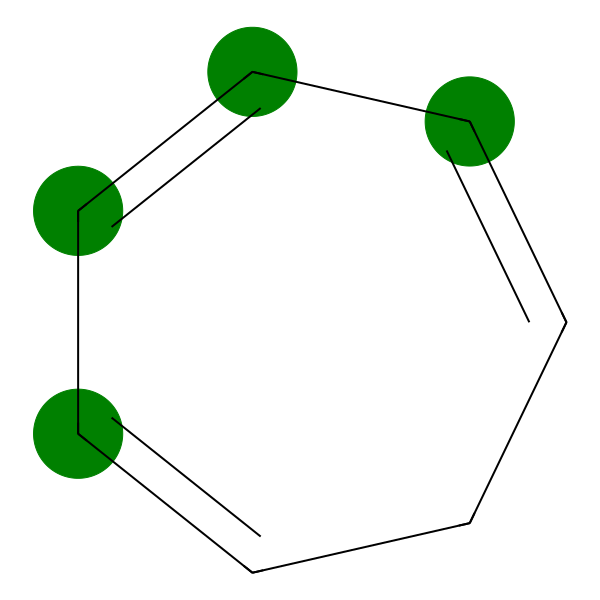

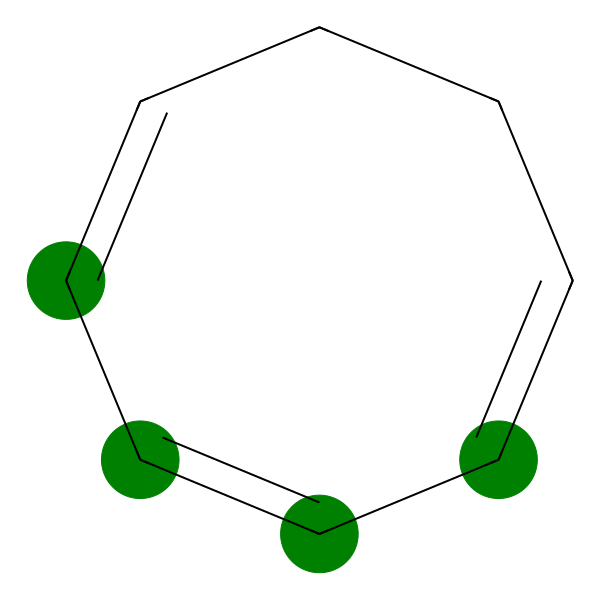

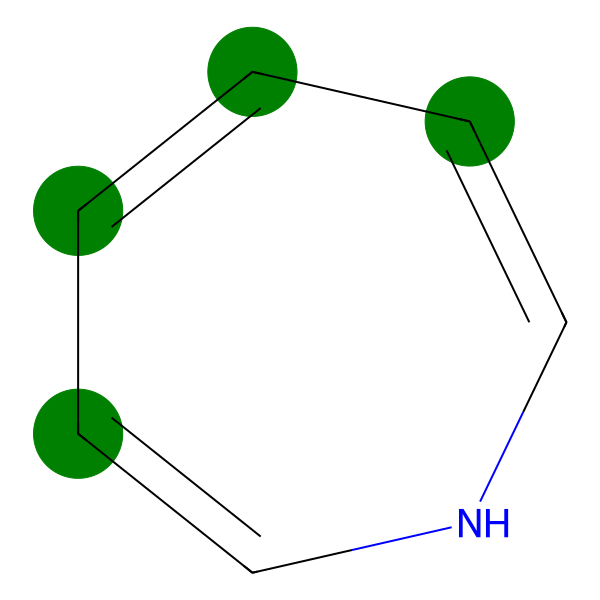

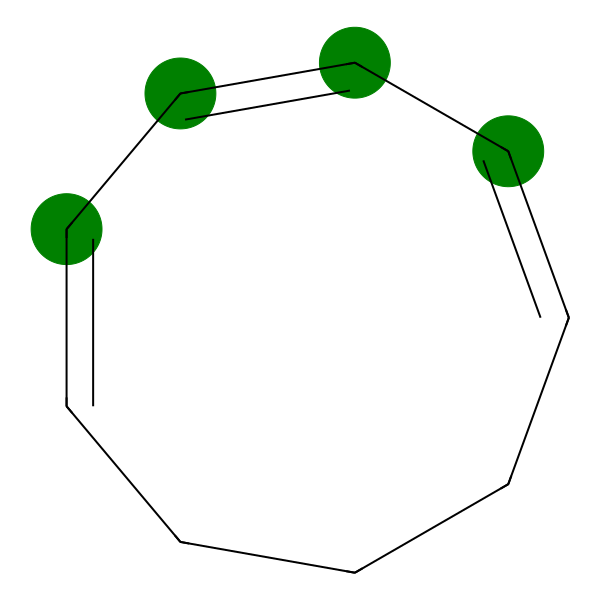

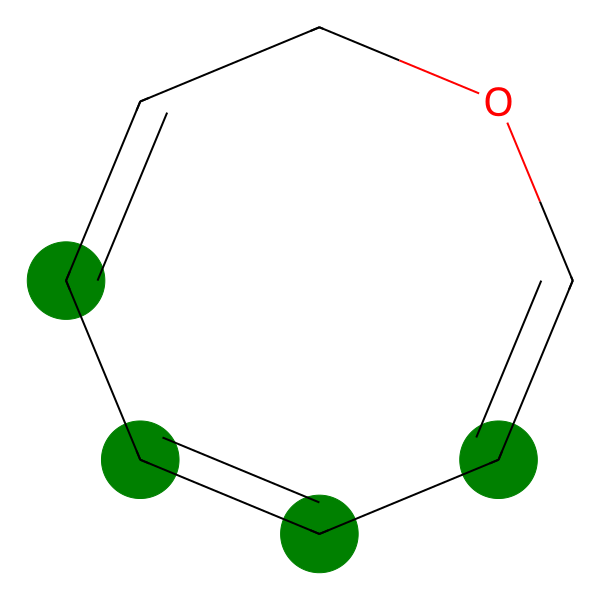

In [7]:
from IPython.display import Image

for img in image_list:
    display(img)

As we can see above, 5 out of 5 of the model's MLM predictions are chemically valid. Overall, the model seems to understand syntax with a pretty decent degree of certainity. 

However, further training on a more specific dataset (say leads for a specific target) may generate a stronger chemical transformer model. Let's now fine-tune our model on a dataset of our choice, ClinTox. You can run ChemBERTa on any MoleculeNet dataset, but for the sake of convinience, we will use ClinTox as it is small and trains quickly.

# What is attention?
Previously, recurrent models struggled with generating a fixed-length vector for large sequences, leading to deteriorating performance as the length of an input sequence increased. 

Attention is, to some extent, motivated by how we pay visual attention to different regions of our vision or how we correlate words in a sentence. Human visual attention allows us to focus on a certain subregion with a higher focus while perceiving the surrounding image in with a lower focus, and then adjust the focal point. 

Similarly, we can explain the relationship between words in one sentence or close context. When we see “eating”, we expect to read a food word very soon. The color term describes the food, but probably not as directly as “eating” does


The attention mechanism extends on the encoder-decoder model, by taking in three values for a SMILES sequence: a value vector (V), a query vector (Q) and a key vector (K). 

Each vector is similar to a type of word embedding, specifically for determining the compatibility of neighbouring tokens. From these vectors, a dot production attention is derived from the dot product of the query vector of one word, and the key vector of the other. 

A scaling factor of $\frac{1}{\sqrt{d_k}}$is added to the dot product attention such that the value doesn't grow too large in respect to $d_k$, the dimension of the key. The softmax normalization function is applied to return a score between 0 to 1 for each individual token:

\begin{equation}
    \textrm{Attention}(Q, K, V) = \textrm{softmax} \left (\frac{QK^T}{\sqrt{d_k}} \right )V
\end{equation}



# Visualizing the Attention Mechanism in ChemBERTa using BertViz

[BertViz](https://github.com/jessevig/bertviz) is a tool for visualizing attention in the Transformer model, supporting all models from the transformers library (BERT, GPT-2, XLNet, RoBERTa, XLM, CTRL, etc.). It extends the Tensor2Tensor visualization tool by Llion Jones and the transformers library from HuggingFace.

Using this tool, we can easily plug in ChemBERTa from the HuggingFace model hub and visualize the attention patterns produced by one or more attention heads in a given transformer layer. This is known as the attention-head view.

Lets start by obtaining a Javascript object for d3.js and jquery to create interactive visualizations:


In [8]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min',
      jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
  }
});

<IPython.core.display.Javascript object>

In [9]:
def call_html():
    import IPython

    display(
        IPython.core.display.HTML(
            """
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.8/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        """
        )
    )

Now, we create an instance of ChemBERTa, tokenize a set of SMILES strings, and compute the attention for each head in the transformer. There are two available models hosted by DeepChem on HuggingFace's model hub, one being `seyonec/ChemBERTa-zinc-base-v1` which is the ChemBERTa model trained via masked lagnuage modelling (MLM) on the ZINC100k dataset, and the other being `seyonec/ChemBERTa-zinc250k-v1`, which is trained via MLM on the larger ZINC250k dataset.




In the following example, we take two SMILES molecules from the ZINC database with nearly identical chemical structure, the only difference being rooted in chiral specification (hence the additional `‘@‘` symbol). This is a feature of molecules which indicates that there exists tetrahedral centres. `‘@'` tells us whether the neighbours of a molecule appear in a counter-clockwise order, whereas `‘@@‘` indicates that the neighbours are ordered in a clockwise direction. The model should ideally refer to similar substructures in each SMILES string with a higher attention weightage. 

Lets look at the first SMILES string: `CCCCC[C@@H](Br)CC`:





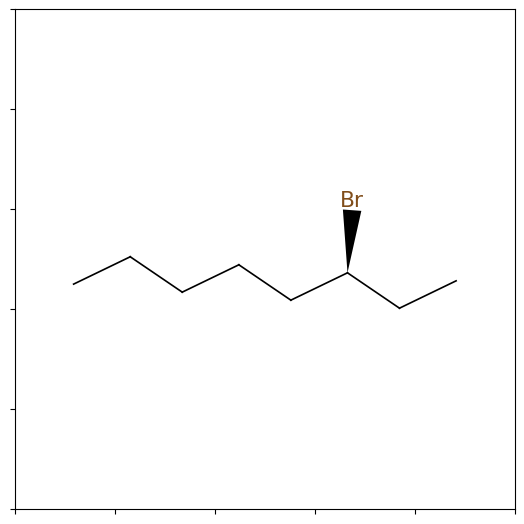

In [10]:
m = Chem.MolFromSmiles("CCCCC[C@@H](Br)CC")
fig = Draw.MolToMPL(m, size=(200, 200))

And the second SMILES string, `CCCCC[C@H](Br)CC`:


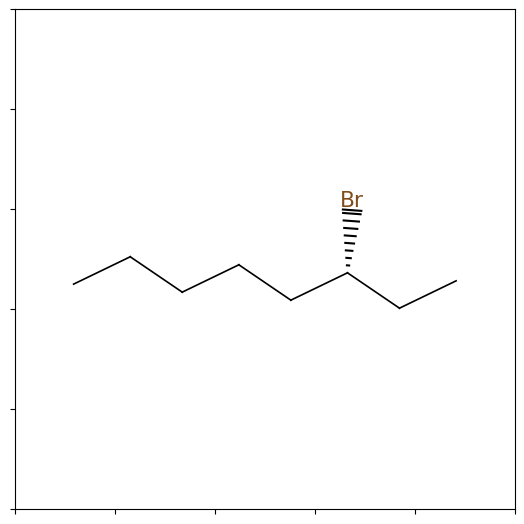

In [11]:
m = Chem.MolFromSmiles("CCCCC[C@H](Br)CC")
fig = Draw.MolToMPL(m, size=(200, 200))

The visualization below shows the attention induced by a sample input SMILES. This view visualizes attention as lines connecting the tokens being updated (left) with the tokens being attended to (right), following the design of the figures above. Color intensity reflects the attention weight; weights close to one show as very dark lines, while weights close to zero appear as faint lines or are not visible at all. The user may highlight a particular SMILES character to see the attention from that token only. This visualization is called the attention-head view. It is based on the excellent Tensor2Tensor visualization tool, and are all generated by the [Bertviz](https://github.com/jessevig/bertviz) library.


In [12]:
from transformers import RobertaModel, RobertaTokenizer
from bertviz import head_view

model_version = "seyonec/PubChem10M_SMILES_BPE_450k"
model = RobertaModel.from_pretrained(model_version, output_attentions=True)
tokenizer = RobertaTokenizer.from_pretrained(model_version)

sentence_a = "CCCCC[C@@H](Br)CC"
sentence_b = "CCCCC[C@H](Br)CC"
inputs = tokenizer.encode_plus(
    sentence_a, sentence_b, return_tensors="pt", add_special_tokens=True
)
input_ids = inputs["input_ids"]
attention = model(input_ids)[-1]
input_id_list = input_ids[0].tolist()  # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)

call_html()

head_view(attention, tokens)

Some weights of the model checkpoint at seyonec/PubChem10M_SMILES_BPE_450k were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<IPython.core.display.Javascript object>

# Smiles-Tokenizer Attention by Head View
![alt text](https://media.giphy.com/media/zpfTwb3Og65ifEWymt/giphy.gif)

The visualization shows that attention is highest between words that don’t cross a boundary between the two SMILES strings; the model seems to understand that it should relate tokens to other tokens in the same molecule in order to best understand their context.

There are many other fascinating visualizations we can do, such as a neuron-by neuron analysis of attention or a model overview that visualizes all of the heads at once:

# Attention by Head View:
![alt text](https://media.giphy.com/media/cLGrM5gfbqj63k2bU2/giphy.gif)
# Model View:
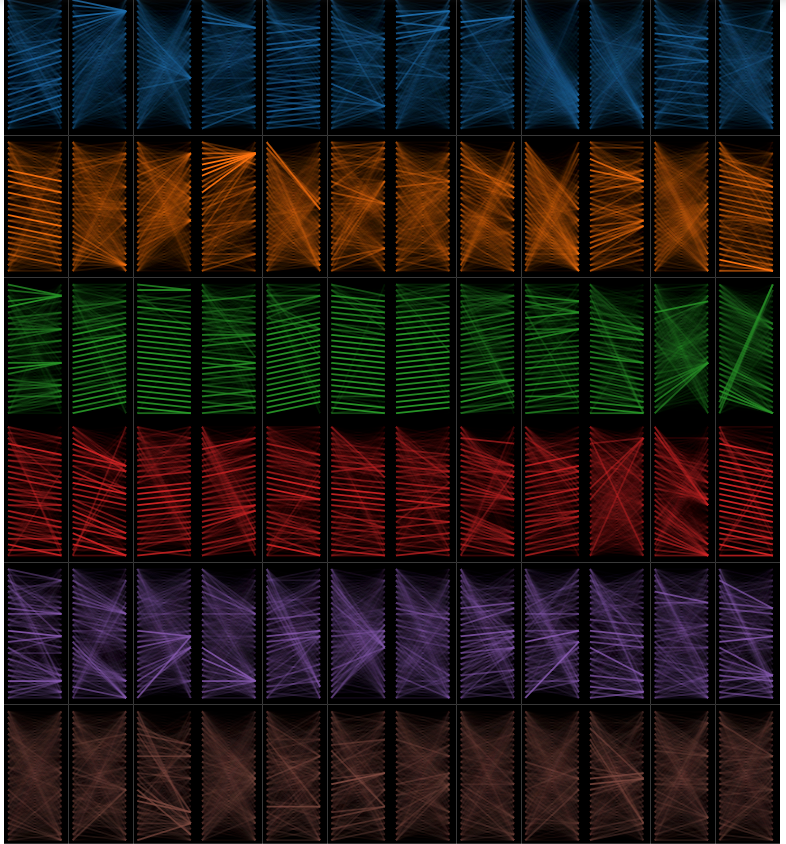

# Neuron-by-neuron view:




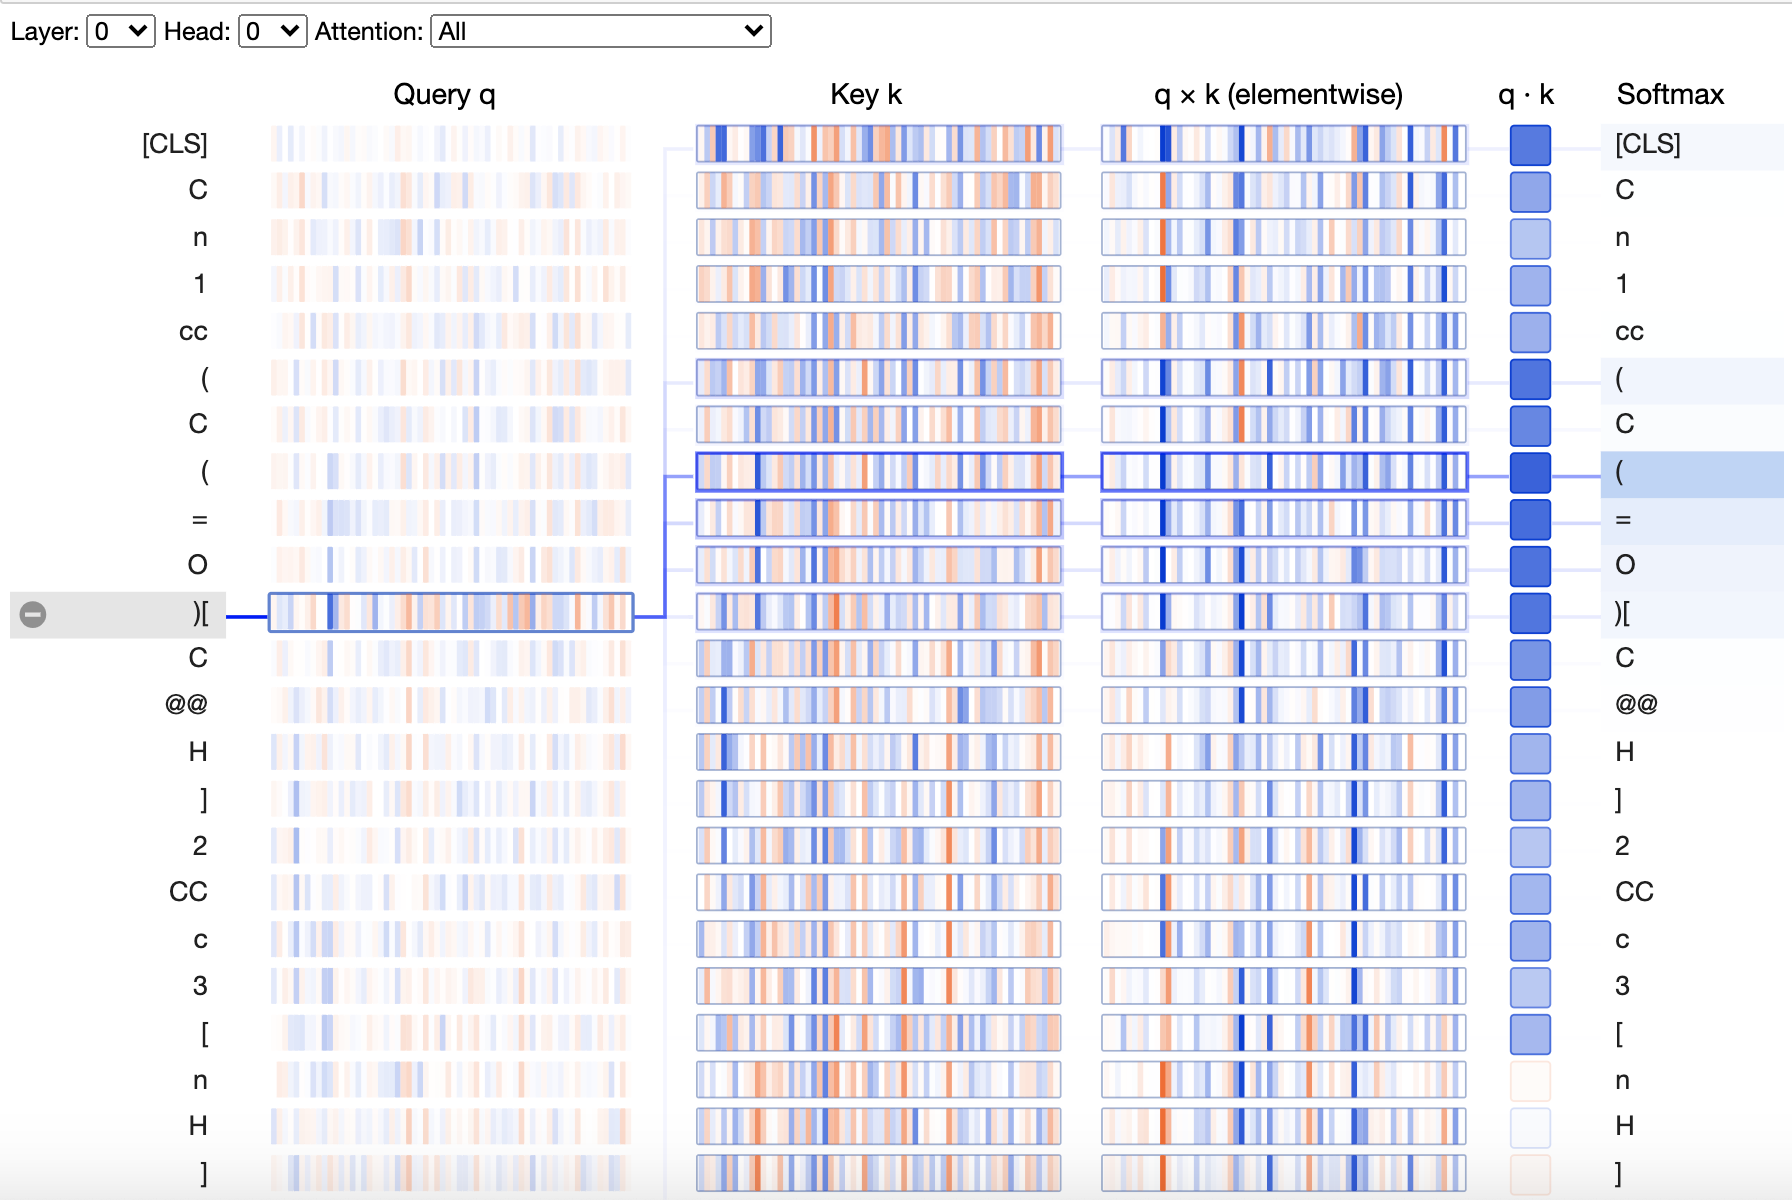

You can try out the ChemBERTa attention visualization demo's in more detail, with custom SMILES/SELFIES strings, tokenizers, and more in the public library, [here](https://github.com/seyonechithrananda/bert-loves-chemistry).